### Bayesian Decision

Use Case with modifications from the Probabilistic models.

Compute distributions over the possible states of $p(H=h |X=x)$ - what we name **belief state**, and ultimately we convert the beliefs into action.

Optimal way to make decision under uncertainty is by using the **decision theory**. When the decision maker picks an **action** $a \in calculate{A}$ and the true **state** is $h \in calculate{H}$, we assume they incur a loss of $\ell(h,a)$. Since the state is usually hidden, we compute the expected loss or risk for each action:
- $R(a|x) = \sum_{h \in cal{H}} p(h|x) \ell(h ; a)$
- The optimal policy specifies which action to take for each possible observation as to minimize the risk $ a^* = \pi^*(x) = \arg \min_{a \in cal{A}} \sum_{h \in cal{H}} p(h|x) \ell(h ; a) $
- We maximize expected utility
$ a^* = \pi^*(x) = \arg \max_{a \in \cal{A}} \sum_{h \in \cal{H}} p(h|x) U(h,a) $


### Optimal policy for Covid-19 patients

#### Background:
- The doctor can give drug to the patient or not
- Assume the patients have or not the Covid-19, and are at a young or old age
- Assume age is a visible variable, but Covid status is hidden
- The doctor can use Bayes rule to infer $p(h|x)$ where $x$ is a diagnostic test
- Given the belief state, we compute the optimal policy
- As a resultm the drug should be given to young people who tested postive
- If we reduce the cost of the drug we get new optimal policy

#### Decision Theoretic Classification

In classification problems, the unknown state is the true class label $y^* \in cal{Y}$ where $cal{Y} = {1}, \dots, C$.


- Assume that the set of possible actions is to pick one of the labels $\hat{y} \in cal{Y}$. e often assume zero-one loss matrix $\ell(h, a)$

- Assume zero-ne loss matrix $$ \begin{array}{c|cc} & \hat{y}=0 & \hat{y}=1 \\ \hline y^*=0 & 0 & 1 \\ y^*=1 & 1 & 0
\end{array} $$


- The loss function $$\ell(y^*, \hat{y}) = |(y^* \neq \hat{y})$$

- The posterior expected loss
$$ R(\hat{y}|x) = p(\hat{y} \neq y^* |x) = 1-p(y^*=\hat{y}|x)$$

- The action to minimize the expected loss is to chose the most probable label, which is the maximum posterior or MAP estimate
$$ \pi(x) = \arg \max_{y \in cal{Y}} p(y|x) $$

#### Classification with reject option

In some applications the loss is assymetric, the cost of false positives is higher than the cost of false negatives. To allow for **rejection option**, we refuse to classify if unncertain. The loss function is defined as
$$ \ell(h, a) = \left\{ \begin{array}{cc} 0 & \mbox{if $h=a$ and $a \in \{1,\ldots,C\}$}\\
\lambda_r & \mbox{if $a=0$}\\ \lambda_e & \mbox{otherwise} \end{array} \right. $$


Show the optimal policy

$$ \begin{align} a^* &= \begin{cases} y^* & \text{ if } p(y^*|x) > 1-\frac{\lambda_r}
{\lambda_e} \\ \text{reject} & \text{otherwise} \end{cases} \end{align} $$


where $y^* = \arg \max_{y} p(y|x)$ is the MAP estimate.

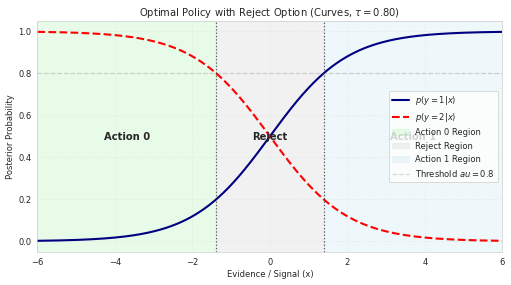

In [ ]:
''' the decision regions by mapping the posterior probabilities to specific actions '''

### Implementation

In [1]:
import numpy as np
import pandas as pd

In [2]:
def loss_fn(loss_drug=8):
    loss_covid_young = 60
    loss_covid_old = 10
    loss_mx = np.zeros((4,2))
    loss_mx[0, :] = [0, loss_drug]
    loss_mx[1, :] = [loss_covid_young, loss_drug]
    loss_mx[2, :] = [0, loss_drug]
    loss_mx[3, :] = [loss_covid_old, loss_drug]
    return loss_mx

In [3]:
loss_mx = loss_fn()
records = []
records.append(('No Covid, young', loss_mx[0,0], loss_mx[0,1]))
records.append(('Covid, young', loss_mx[1,0], loss_mx[1,1]))
records.append(('No Covid, old', loss_mx[2,0], loss_mx[2,1]))
records.append(('Covid, young', loss_mx[3,0], loss_mx[3,1]))
df = pd.DataFrame.from_records(records, columns=['State', 'No Drug', 'Drug'])
df,

(             State  No Drug  Drug
 0  No Covid, young      0.0   8.0
 1     Covid, young     60.0   8.0
 2    No Covid, old      0.0   8.0
 3     Covid, young     10.0   8.0,)

In [4]:
def normalize(x):
    return x / np.sum(x)

In [5]:
def posterior_covid(observed, prevalence=None, sensitivity=None):
    if sensitivity is None:
        sensitivity = 0.1
    specificity = 0.975
    TPR = sensitivity
    FNR = 1 - TPR
    TNR = specificity
    FPR = 1 - TNR
    likelihood_fn = np.array([[TNR, FPR], [FNR, TPR]])
    if prevalence is None:
        prevalence = 0.1
    prior = np.array([1 - prevalence, prevalence])
    likelihood = likelihood_fn[:, observed].T # likelihood_fn[observed, :]
    posterior = normalize(likelihood * prior)
    return posterior

In [6]:
def compute_belief(observed, prevalence=None, sensitivity=None):
    test_result, age = observed
    ''' returns beliefs[0:3] for states (not-covid+not-old, covid+not-old, not-covid+old, covid+old) '''
    post = posterior_covid(test_result, prevalence, sensitivity)
    belief_ = np.zeros(4)
    if age ==0: belief_[0:2] = post
    else: belief_[2:4] = post
    return belief_

def policy(observed):
    belief = compute_belief(observed)
    loss_mx = loss_fn(loss_drug=8)
    expected_loss = np.dot(belief, loss_mx)
    return np.argmin(expected_loss)

In [7]:
def make_table(cost_drug, prevalence=None, sensitivity=None):
    records = []
    for test_result in range(2):
        for age in range(2):
            observed = (test_result, age)
            belief_ = compute_belief(observed, prevalence, sensitivity)
            loss_mx = loss_fn(cost_drug)
            expected_loss = np.dot(belief_, loss_mx)
            act = np.argmin(expected_loss)
            if age ==0: post_covid = belief_[1]
            else: post_covid = belief_[3]
            records.append((test_result, age, post_covid, expected_loss))

    df = pd.DataFrame.from_records(records, columns=['test', 'age', 'pr(covid)', 'cost-noop', 'cost-drug', 'action'])
    return df

In [8]:
def make_table(cost_drug, prevalence=None, sensitivity=None):
    records = []
    for test_result in range(2):
        for age in range(2):
            observed = (test_result, age)
            belief_ = compute_belief(observed, prevalence, sensitivity)
            loss_mx = loss_fn(cost_drug)
            expected_loss = np.dot(belief_, loss_mx)
            act = np.argmin(expected_loss)
            if age == 0:
                post_covid = belief_[1]
            else:
                post_covid = belief_[3]
            # Unpack the two costs from expected_loss and include the chosen action
            records.append((test_result, age, post_covid, expected_loss[0], expected_loss[1], act))

    df = pd.DataFrame.from_records(records, columns=['test', 'age', 'pr(covid)', 'cost-noop', 'cost-drug', 'action'])
    return df

In [9]:
df = make_table(cost_drug=8)
df,

(   test  age  pr(covid)  cost-noop  cost-drug  action
 0     0    0   0.093023   5.581395        8.0       0
 1     0    1   0.093023   0.930233        8.0       0
 2     1    0   0.307692  18.461538        8.0       1
 3     1    1   0.307692   3.076923        8.0       0,)

In [10]:
df = make_table(cost_drug=5)
df,

(   test  age  pr(covid)  cost-noop  cost-drug  action
 0     0    0   0.093023   5.581395        5.0       1
 1     0    1   0.093023   0.930233        5.0       0
 2     1    0   0.307692  18.461538        5.0       1
 3     1    1   0.307692   3.076923        5.0       0,)

In [11]:
df = make_table(cost_drug=8, sensitivity=0.975)
df,

(   test  age  pr(covid)  cost-noop  cost-drug  action
 0     0    0   0.002841   0.170455        8.0       0
 1     0    1   0.002841   0.028409        8.0       0
 2     1    0   0.812500  48.750000        8.0       1
 3     1    1   0.812500   8.125000        8.0       1,)

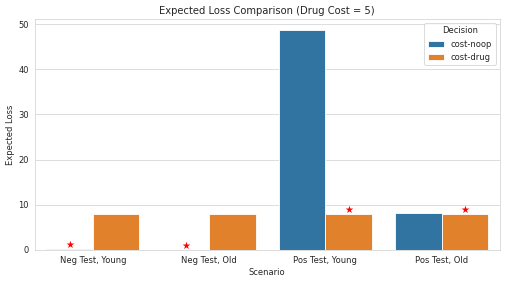

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map patient scenario codes to descriptive labels
scenario_map = {(0, 0): 'Neg Test, Young', (0, 1): 'Neg Test, Old', (1, 0): 'Pos Test, Young', (1, 1): 'Pos Test, Old'}
df_viz = df.copy()
df_viz['Scenario'] = [scenario_map[(int(t), int(a))] for t, a in zip(df_viz['test'], df_viz['age'])]

# Reshape data for side-by-side bar comparison
df_melted = df_viz.melt(id_vars=['Scenario', 'action'], value_vars=['cost-noop', 'cost-drug'], var_name='Decision', value_name='Expected Loss')

plt.figure(figsize=(10, 5), dpi=60)
sns.set_style('whitegrid')
ax = sns.barplot(data=df_melted, x='Scenario', y='Expected Loss', hue='Decision')
plt.title('Expected Loss Comparison (Drug Cost = 5)')

# Annotate the optimal action per scenario
for i, row in df_viz.iterrows():
    # hue order: cost-noop (left), cost-drug (right)
    x_pos = i - 0.2 if row['action'] == 0 else i + 0.2
    y_pos = row['cost-noop'] if row['action'] == 0 else row['cost-drug']
    plt.text(x_pos, y_pos + 0.2, '★', color='red', ha='center', weight='bold', fontsize=12)

plt.show()

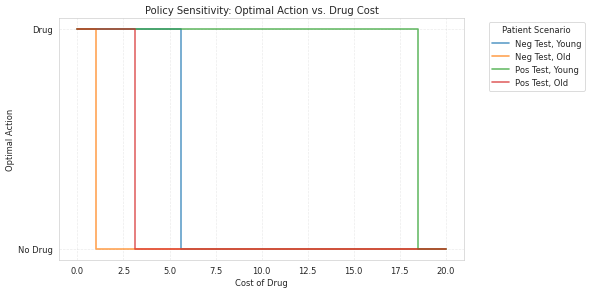

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Sensitivity Analysis: Optimal Action vs. Drug Cost
drug_costs = np.linspace(0, 20, 200)
scenarios = ['Neg Test, Young', 'Neg Test, Old', 'Pos Test, Young', 'Pos Test, Old']
# Compute optimal action for each scenario across a range of costs
results = np.array([make_table(cost_drug=c)['action'].values for c in drug_costs])

plt.figure(figsize=(10, 5), dpi=60)
for i in range(4):
    plt.step(drug_costs, results[:, i], label=scenarios[i], where='post', alpha=0.7, linewidth=2)

plt.yticks([0, 1], ['No Drug', 'Drug'])
plt.xlabel('Cost of Drug')
plt.ylabel('Optimal Action')
plt.title('Policy Sensitivity: Optimal Action vs. Drug Cost')
plt.legend(title='Patient Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Perform a sensitivity analysis to determine how the diagnostic test's sensitivity (ranging from 0.1 to 1.0) affects the optimal treatment decision (Drug vs. No Drug) for young and old patients with positive or negative test results, assuming a fixed drug cost of 5.

In [16]:
''' Calculate the optimal actions for a range of sensitivity values to analyze how test sensitivity impacts medical decisions '''
sensitivities = np.linspace(0.1, 1.0, 200)
scenarios = ['Neg Test, Young', 'Neg Test, Old', 'Pos Test, Young', 'Pos Test, Old']
sensitivity_results = []

for s in sensitivities:
    # Generate table for current sensitivity with fixed drug cost
    temp_df = make_table(cost_drug=5, sensitivity=s)
    # Extract actions for the 4 scenarios
    sensitivity_results.append(temp_df['action'].values)

# Convert to numpy array: shape (200, 4)
sensitivity_results = np.array(sensitivity_results)

print(f'Computed actions for {len(sensitivities)} sensitivity values.')
print(f'Results shape: {sensitivity_results.shape}')
print('First 5 rows (Actions):')
print(sensitivity_results[:5])

Computed actions for 200 sensitivity values.
Results shape: (200, 4)
First 5 rows (Actions):
[[1 0 1 0]
 [1 0 1 0]
 [1 0 1 0]
 [1 0 1 0]
 [1 0 1 0]]


The transitions in optimal policy for all four patient scenarios and the impact of test sensitivity on treatment strategies for different age groups.


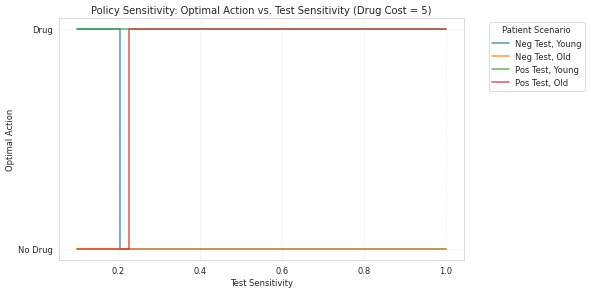

In [17]:
plt.figure(figsize=(10, 5), dpi=60)
for i in range(4):
    plt.step(sensitivities, sensitivity_results[:, i], label=scenarios[i], where='post', alpha=0.7, linewidth=2)

plt.yticks([0, 1], ['No Drug', 'Drug'])
plt.xlabel('Test Sensitivity')
plt.ylabel('Optimal Action')
plt.title('Policy Sensitivity: Optimal Action vs. Test Sensitivity (Drug Cost = 5)')
plt.legend(title='Patient Scenario', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Implement a Bayesian decision rule with a "reject" option by defining losses for rejection ($\lambda_r$) and errors ($\lambda_e$) to calculate a decision threshold $\tau = 1 - \frac{\lambda_r}{\lambda_e}$. Show the decision regions for "Action 0", "Action 1", and "Reject" as a function of the posterior probability $p(y=1|x)$, and how this threshold influences decision-making compared to the standard MAP approach.

In [18]:
''' Define the costs for rejection and errors and calculate the corresponding decision threshold '''
lambda_r = 10
lambda_e = 50

# Calculate the decision threshold tau
tau = 1 - (lambda_r / lambda_e)

# Generate a range of posterior probabilities for class y=1
p_y1_x = np.linspace(0, 1, 500)

print(f'Loss for rejection (lambda_r): {lambda_r}')
print(f'Loss for error (lambda_e): {lambda_e}')
print(f'Calculated Decision Threshold (tau): {tau}')

Loss for rejection (lambda_r): 10
Loss for error (lambda_e): 50
Calculated Decision Threshold (tau): 0.8


Visualize the decision regions by mapping the posterior probabilities to specific actions (Action 0, Action 1, or Reject) based on the threshold tau, and the shaded regions and annotations to clearly illustrate the decision boundaries.



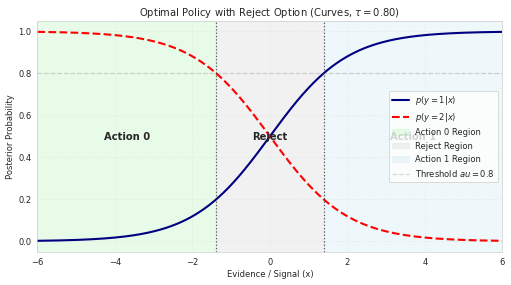

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate a signal range x
x_signal = np.linspace(-6, 6, 500)

# Compute sigmoid curves for posterior probabilities
p_y1_given_x = 1 / (1 + np.exp(-x_signal))
p_y2_given_x = 1 - p_y1_given_x

# Calculate the corresponding signal thresholds for tau
# p = 1 / (1 + exp(-x)) => x = -log((1/p) - 1)
x_threshold_high = -np.log((1/tau) - 1)
x_threshold_low = -np.log((1/(1-tau)) - 1)

plt.figure(figsize=(10, 5), dpi=60)

# Plot the probability curves
plt.plot(x_signal, p_y1_given_x, color='navy', label='$p(y=1|x)$', linewidth=2.5)
plt.plot(x_signal, p_y2_given_x, color='red', label='$p(y=2|x)$', linewidth=2.5, linestyle='--')

# Shading the decision regions in signal space
plt.axvspan(x_signal.min(), x_threshold_low, color='lightgreen', alpha=0.2, label='Action 0 Region')
plt.axvspan(x_threshold_low, x_threshold_high, color='lightgray', alpha=0.3, label='Reject Region')
plt.axvspan(x_threshold_high, x_signal.max(), color='lightblue', alpha=0.2, label='Action 1 Region')

# Adding vertical dashed lines at thresholds in signal space
plt.axvline(x_threshold_low, color='black', linestyle=':', alpha=0.6)
plt.axvline(x_threshold_high, color='black', linestyle=':', alpha=0.6)

# Horizontal threshold line
plt.axhline(tau, color='gray', linestyle='--', alpha=0.3, label=f'Threshold $\tau={tau}$')

# Adding text annotations for the regions
plt.text((x_signal.min() + x_threshold_low) / 2, 0.5, 'Action 0', ha='center', va='center', fontweight='bold', fontsize=12)
plt.text(0, 0.5, 'Reject', ha='center', va='center', fontweight='bold', fontsize=12)
plt.text((x_signal.max() + x_threshold_high) / 2, 0.5, 'Action 1', ha='center', va='center', fontweight='bold', fontsize=12)

# Formatting the plot
plt.xlabel('Evidence / Signal (x)')
plt.ylabel('Posterior Probability')
plt.title(f'Optimal Policy with Reject Option (Curves, $\\tau={tau:.2f}$)')
plt.legend(loc='best', frameon=True)
plt.xlim(x_signal.min(), x_signal.max())
plt.ylim(-0.05, 1.05)
plt.grid(axis='both', linestyle=':', alpha=0.5)
plt.show()